<a href="https://colab.research.google.com/github/pas3n7/ColabDataScienceLearning/blob/main/ConvoPytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [19]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

DOWNLOAD_FILES = False
SETUP_DATASET = False
DATASETPATH = r'/content/drive/MyDrive/Data/CatsDogs/'

#dataset stuff

IMG_SIZE = 64
CATS = DATASETPATH + "PetImages/Cat/"
DOGS = DATASETPATH + "PetImages/Dog/"
LABELS = {CATS: 0, DOGS: 1}
training_data = []


#training stuff
NUM_EPOCHS = 1
TESTSET_PCT = 0.1 #Testset 1% of all data, train on 99%
BATCH_SIZE = 100

In [20]:
#### File get and setup

if DOWNLOAD_FILES == True:
    import urllib.request
    url = r'https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_3367a.zip'
    zippath = r'/content/kagglecatsdogs.zip'
    

    urllib.request.urlretrieve(url, zippath)
    import zipfile
    with zipfile.ZipFile(zippath, 'r') as zip_ref:
        zip_ref.extractall(DATASETPATH)
    

In [21]:
#dataset prep class




def make_training_data():
    for label in LABELS:
        for f in tqdm(os.listdir(label)):
            if "jpg" in f:
                try:
                    path = os.path.join(label, f)
                    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
                    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
                    training_data.append([np.array(img), np.eye(2)[LABELS[label]]])
                except Exception as e:
                    #print(label, f, str(e))
                    continue
    np.random.shuffle(training_data)


if SETUP_DATASET == True:
    make_training_data()


/content/drive/MyDrive/Data/CatsDogs/PetImages/Cat/ 10125.jpg OpenCV(4.1.2) /io/opencv/modules/imgproc/src/resize.cpp:3720: error: (-215:Assertion failed) !ssize.empty() in function 'resize'

/content/drive/MyDrive/Data/CatsDogs/PetImages/Cat/ 10404.jpg OpenCV(4.1.2) /io/opencv/modules/imgproc/src/resize.cpp:3720: error: (-215:Assertion failed) !ssize.empty() in function 'resize'

/content/drive/MyDrive/Data/CatsDogs/PetImages/Cat/ 10501.jpg OpenCV(4.1.2) /io/opencv/modules/imgproc/src/resize.cpp:3720: error: (-215:Assertion failed) !ssize.empty() in function 'resize'

/content/drive/MyDrive/Data/CatsDogs/PetImages/Cat/ 10820.jpg OpenCV(4.1.2) /io/opencv/modules/imgproc/src/resize.cpp:3720: error: (-215:Assertion failed) !ssize.empty() in function 'resize'

/content/drive/MyDrive/Data/CatsDogs/PetImages/Cat/ 11210.jpg OpenCV(4.1.2) /io/opencv/modules/imgproc/src/resize.cpp:3720: error: (-215:Assertion failed) !ssize.empty() in function 'resize'

/content/drive/MyDrive/Data/CatsDogs/Pet

/content/drive/MyDrive/Data/CatsDogs/PetImages/Dog/ 10158.jpg OpenCV(4.1.2) /io/opencv/modules/imgproc/src/resize.cpp:3720: error: (-215:Assertion failed) !ssize.empty() in function 'resize'

/content/drive/MyDrive/Data/CatsDogs/PetImages/Dog/ 10401.jpg OpenCV(4.1.2) /io/opencv/modules/imgproc/src/resize.cpp:3720: error: (-215:Assertion failed) !ssize.empty() in function 'resize'

/content/drive/MyDrive/Data/CatsDogs/PetImages/Dog/ 10747.jpg OpenCV(4.1.2) /io/opencv/modules/imgproc/src/resize.cpp:3720: error: (-215:Assertion failed) !ssize.empty() in function 'resize'

/content/drive/MyDrive/Data/CatsDogs/PetImages/Dog/ 10797.jpg OpenCV(4.1.2) /io/opencv/modules/imgproc/src/resize.cpp:3720: error: (-215:Assertion failed) !ssize.empty() in function 'resize'

/content/drive/MyDrive/Data/CatsDogs/PetImages/Dog/ 11410.jpg OpenCV(4.1.2) /io/opencv/modules/imgproc/src/resize.cpp:3720: error: (-215:Assertion failed) !ssize.empty() in function 'resize'

/content/drive/MyDrive/Data/CatsDogs/Pet

shape:  (64, 64)


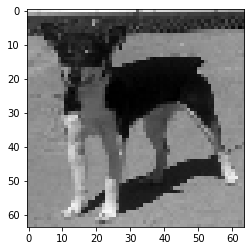

[0. 1.]


In [22]:
plt.imshow(training_data[5][0], cmap="gray")
print("shape: ", training_data[0][0].shape)
plt.show()
print(training_data[5][1])

In [62]:
class Net(nn.Module):
    def __init__(self):
        super().__init__() #run the super init
        #for output size == input size, need padding 2
        self.conv1 = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=5, stride=1, padding=2), #Padding 2, output size = input size
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        #output will be half size, 32x32
        self.conv2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=5, stride=1, padding=2), #Padding 2, output size = input size
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        #output will be half size, 16x16
        self.drop_out = nn.Dropout()
        self.fc1 = nn.Linear(16*16*64, 1000)
        self.fc2 = nn.Linear(1000, 2)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = x.reshape(x.size(0), -1)
        x = self.fc1(x)
        x = self.fc2(x)
        return F.softmax(x, dim=1) 

In [24]:
net = Net()

optimizer = optim.Adam(net.parameters(), lr=0.001)
loss_fucnction = nn.MSELoss()

X = torch.Tensor([i[0] for i in training_data]).view(-1, 64, 64)
X = X/255.0 #scaling from 0-255 to 0-1
y = torch.Tensor([i[1] for i in training_data])

testset_size = int(len(X)*TESTSET_PCT)
print(testset_size)
train_X = X[:-testset_size]
train_y = y[:-testset_size]

test_X = X[:testset_size]
test_y = y[:testset_size]

2494


In [25]:
print(len(train_X))
print(len(test_X))

22452
2494


In [26]:
#####----- Training Loop -----#####
for epoch in range(NUM_EPOCHS):
    for i in tqdm(range(0, len(train_X), BATCH_SIZE)):
        #print(i, i+BATCH_SIZE)
        batch_X = train_X[i:i+BATCH_SIZE].view(-1, 1, 64, 64)
        batch_y = train_y[i:i+BATCH_SIZE]
        net.zero_grad()
        outputs = net(batch_X)
        loss = loss_fucnction(outputs, batch_y)
        loss.backward()
        optimizer.step()
    print(i, " : ", loss, end='\r')

tensor(0.2490, grad_fn=<MseLossBackward>)
tensor(0.5100, grad_fn=<MseLossBackward>)
tensor(0.5600, grad_fn=<MseLossBackward>)
tensor(0.4600, grad_fn=<MseLossBackward>)
tensor(0.5300, grad_fn=<MseLossBackward>)
tensor(0.5600, grad_fn=<MseLossBackward>)
tensor(0.5300, grad_fn=<MseLossBackward>)
tensor(0.5000, grad_fn=<MseLossBackward>)
tensor(0.4400, grad_fn=<MseLossBackward>)
tensor(0.5300, grad_fn=<MseLossBackward>)
tensor(0.5100, grad_fn=<MseLossBackward>)
tensor(0.5500, grad_fn=<MseLossBackward>)
tensor(0.4800, grad_fn=<MseLossBackward>)
tensor(0.4700, grad_fn=<MseLossBackward>)
tensor(0.5600, grad_fn=<MseLossBackward>)
tensor(0.5600, grad_fn=<MseLossBackward>)
tensor(0.4100, grad_fn=<MseLossBackward>)
tensor(0.4600, grad_fn=<MseLossBackward>)
tensor(0.6100, grad_fn=<MseLossBackward>)
tensor(0.5100, grad_fn=<MseLossBackward>)
tensor(0.5600, grad_fn=<MseLossBackward>)
tensor(0.5400, grad_fn=<MseLossBackward>)
tensor(0.4000, grad_fn=<MseLossBackward>)
tensor(0.4700, grad_fn=<MseLossBac

In [27]:
## test accuracy
correct = 0
total = 0
with torch.no_grad():
    for i in tqdm(range(len(test_X))):
        real_class = torch.argmax(test_y[i])
        net_out = net(test_X[i].view(-1,1,64,64))[0]

        predicted_class = torch.argmax(net_out)
        if predicted_class == real_class:
            correct+= 1
        total += 1
print(f'Accuracy: {round(correct/total, 3)}')


Accuracy: 0.494


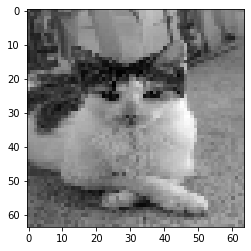

tensor([[0., 1.]])


In [50]:
testind = 3
plt.imshow(test_X[testind], cmap="gray")
plt.show()
with torch.no_grad():
    print(net(test_X[testind].view(1, 1, 64, 64)))

In [39]:
test_X[testind].view(-1, 1, 64, 64).shape

torch.Size([1, 1, 64, 64])

In [ ]:
2